In [3]:
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

#from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import precision_recall_curve, average_precision_score
#from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#import matplotlib.pyplot as plt
import shap

#import numpy as np
#import pandas as pd
#from pathlib import Path
from tqdm import tqdm
#import json
#import uuid
import time
#import os

#import seaborn as sns

#from scipy.special import expit  # sigmoid


In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from preprocess import *
from mydataloader import * 
from model_utils import *

C:\Users\sulei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.20) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [ ]:
class SingleBranchCNN(nn.Module):
    def __init__(self, ker_size=2, padd_size=1, dropout_rate=0.4):
        super(SingleBranchCNN, self).__init__()

        self.dropout_rate = dropout_rate
        self.ker_size = ker_size
        self.padd_size = padd_size
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=ker_size, padding=padd_size)  
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)                                        # (B, 16, H/2, W/2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=ker_size, padding=padd_size)            # (B, 32, H/2, W/2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)                                        # (B, 32, H/4, W/4)
        
        self.dropout = nn.Dropout2d(dropout_rate)  # Dropout for feature maps

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        return x  # Output shape: (B, 32, H/4, W/4)
    


class MultiViewCNN(nn.Module):
    def __init__(self, input_size=(65, 65), use_metadata=False, ker_size=2, padd_size=1, dropout_rate=0.4):
        super(MultiViewCNN, self).__init__()

        self.use_metadata = use_metadata
        self.ker_size = ker_size
        self.padd_size = padd_size
        self.dropout_rate = dropout_rate
        H, W = input_size

        # === 1. Three convolutional branches for each view ===
        self.axial_branch = SingleBranchCNN(ker_size, padd_size, dropout_rate)
        self.sagittal_branch = SingleBranchCNN(ker_size, padd_size, dropout_rate)
        self.coronal_branch = SingleBranchCNN(ker_size, padd_size, dropout_rate)

        # === 2. Flattened size after two MaxPool2d(2) layers in each branch ===
        #flattened_size = 32 * (H // 4) * (W // 4)  # each branch output flattened

        # === 3. Learnable attention weights for 3 views ===
        # Initialized randomly, then optimized during training
        self.view_weights = nn.Parameter(torch.randn(3))  # shape: (3,)

        # === 4. Final total input size to the classifier ===
        #total_features = 3 * flattened_size       # all branches
        total_features = 32 * (H // 4) * (W // 4)  # each branch output flattened
        if use_metadata:
            total_features += 2  # e.g. age and gender

        # === 5. Classifier ===
        self.fc1 = nn.Linear(total_features, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 1)  # Binary classification (output: logit)

    def forward(self, axial, sagittal, coronal, meta=None):
        # === Step 1: Pass each view through its CNN branch ===
        a = self.axial_branch(axial)
        s = self.sagittal_branch(sagittal)
        c = self.coronal_branch(coronal)
        
        # === Step 2: Flatten each feature map ===
        a = a.view(a.size(0), -1)  # flatten
        s = s.view(s.size(0), -1)
        c = c.view(c.size(0), -1)
        #print(a.shape, s.shape, c.shape)
        # === Step 3: Stack into shape (B, 3, D) ===
        views = torch.stack([a, s, c], dim=1)  # (B, 3, D)
        
        # === Step 4: Normalize the attention weights using softmax ===
        weights = F.softmax(self.view_weights, dim=0)  # (3,)
        
        # === Step 5: Apply the weights to each view and sum ===
        # weights: (3,) → (1, 3, 1) → (B, 3, D)
        weighted_views = (views * weights.unsqueeze(0).unsqueeze(-1)).sum(dim=1)  # (B, D)
        
        # === Step 6: Concatenate metadata ===
        if self.use_metadata and meta is not None:
            x = torch.cat([weighted_views, meta], dim=1)
        else:
            x = weighted_views


        #x = torch.cat([a, s, c], dim=1)
        #if self.use_metadata and meta is not None:
        #    x = torch.cat([x, meta], dim=1)

        # === Step 7: Feedforward classifier ===
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # raw logit (no sigmoid)
        return x
    


In [6]:
model_df = pd.DataFrame(columns=[
    "timestamp", "optimizer", "Patience", "weight_decay", "threshold_cutoff", "dropout_rate", "padd_size", "ker_size", "Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc", 
    "Learning Rate", "Best Val Loss"
])

performance_df = pd.DataFrame(columns=[
    "timestamp", "auc_score", 
    "normal_precision", "normal_recall", "normal_f1",
    "takotsubo_precision", "takotsubo_recall", "takotsubo_f1",
    "accuracy", "macro_precision", "macro_recall", "macro_f1",
    "weighted_precision", "weighted_recall", "weighted_f1",
    "uncalibrated_brier", "calibrated_brier"
])
os.makedirs("logs", exist_ok=True)


In [7]:
metadata, labels, slices = load_dataset()
dataset = SliceDataset(
    slices_dict=slices,          
    metadata_dict=metadata,      
    labels_dict=labels           
)
takotsubo_count = sum(1 for sample in dataset if sample["label"].item() == 1)
normal_count = sum(1 for sample in dataset if sample["label"].item() == 0)
print(f"Takotsubo: {takotsubo_count}, Normal: {normal_count}")
dataset_loader = DataLoaderModule(dataset, batch_size=1)
train_loader = dataset_loader.get_train_loader()
val_loader = dataset_loader.get_val_loader()
test_loader = dataset_loader.get_test_loader()

tako_train, normal_train = count_labels(train_loader)
tako_val, normal_val = count_labels(val_loader)
tako_test, normal_test = count_labels(test_loader)

# Print results
print(f"Train -> Takotsubo: {tako_train}, Normal: {normal_train}")
print(f"Val   -> Takotsubo: {tako_val}, Normal: {normal_val}")
print(f"Test  -> Takotsubo: {tako_test}, Normal: {normal_test}")

Loading normal_cases
Loading takotsubo_cases
Takotsubo: 81, Normal: 75
Train -> Takotsubo: 57, Normal: 52
Val   -> Takotsubo: 12, Normal: 11
Test  -> Takotsubo: 12, Normal: 12


In [13]:
idx = 0
for batch in test_loader:
    x_axial = batch["axial"]
    x_sagittal = batch["sagittal"]
    x_coronal = batch["coronal"]
    x_meta = batch["meta"]
    y = batch["label"]
    pid = batch["pid"]
    
    print(f"{idx} - {pid} - {y.item()}")
    idx += 1
    #break

0 - ['DL 232051'] - 0.0
1 - ['RNA 36366185'] - 0.0
2 - ['SLE 50347443'] - 0.0
3 - ['PAL 10614444'] - 1.0
4 - ['SA 33363250'] - 0.0
5 - ['MC 3887643'] - 1.0
6 - ['JMCF 8687782'] - 1.0
7 - ['AD 12191953'] - 1.0
8 - ['JL 4008074'] - 1.0
9 - ['AB 10470318'] - 0.0
10 - ['XZC 32444390'] - 1.0
11 - ['NU00147883'] - 0.0
12 - ['GAB 25512591'] - 1.0
13 - ['DEA 9230'] - 0.0
14 - ['JNMP 2291631'] - 1.0
15 - ['PDG 27972884'] - 0.0
16 - ['MDW 22867501'] - 1.0
17 - ['CLB 50002879'] - 1.0
18 - ['MK 25733700'] - 1.0
19 - ['HB 50159284'] - 0.0
20 - ['CB 11607017'] - 0.0
21 - ['AG 519880'] - 0.0
22 - ['JSA 91708HDGH'] - 0.0
23 - ['MMF 40610578'] - 1.0


In [14]:
Patience = 5
kernel_size=3
padding_size=kernel_size // 2
dr_rate=0.3
threshold_cutoff = 0.5  # threshold for binary classification
LR = 1e-5
WD = 1e-3
model = MultiViewCNN(input_size=(65, 65), use_metadata=True, ker_size=kernel_size, padd_size=padding_size, dropout_rate=dr_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
pos_weight = torch.tensor([takotsubo_count / normal_count])  
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=Patience, factor=0.5, verbose=True)

# Early stopping parameters - best val loss set as infinity initially
best_val_loss = float('inf')

patience_counter = 0
num_epochs = 50  # longer max epochs now

train_losses = []
val_losses = []

C:\Users\sulei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [15]:
# Training loop
timestamp = time.strftime("%Y-%m-%d_%H-%M")
print(f"Timestamp: {timestamp}")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        x_axial = batch["axial"].to(device)
        x_sagittal = batch["sagittal"].to(device)
        x_coronal = batch["coronal"].to(device)
        x_meta = batch["meta"].to(device)
        y = batch["label"].to(device)
        #pid = batch["pid"].to(device)

        train_outputs = model(x_axial, x_sagittal, x_coronal, x_meta)
        tr_loss = criterion(train_outputs, y)

        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()

        train_loss += tr_loss.item()
        predicted = (torch.sigmoid(train_outputs) > threshold_cutoff).float()
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # ====== Validation ======
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            x_axial = batch["axial"].to(device)
            x_sagittal = batch["sagittal"].to(device)
            x_coronal = batch["coronal"].to(device)
            x_meta = batch["meta"].to(device)
            y = batch["label"].to(device)

            val_outputs = model(x_axial, x_sagittal, x_coronal, x_meta)
            vl_loss = criterion(val_outputs, y)
            val_loss += vl_loss.item()
            
            preds = (torch.sigmoid(val_outputs) > threshold_cutoff).float()
            val_total += y.size(0)
            val_correct += (preds == y).sum().item()
            

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%| LR: {current_lr:.6f}")
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    # ====== Early stopping check ======
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f"{timestamp}.pt")  # save best model
        print(f"Validation loss improved to {best_val_loss:.4f}. Saving model.")
    else:
        patience_counter += 1
        print(f"No improvement in val loss ({patience_counter}/{Patience})")

        if patience_counter >= Patience:
            print("Early stopping triggered.")
            break
    
    model_df.loc[len(model_df)] = {
    "timestamp": timestamp,
    "optimizer": "Adam",
    "Patience": Patience,
    "weight_decay": WD,
    "threshold_cutoff": threshold_cutoff,
    "dropout_rate": dr_rate,
    "padd_size": padding_size,
    "ker_size": kernel_size,
    "Epoch": epoch + 1,
    "Train Loss": f"{avg_train_loss:.4f}",
    "Val Loss": f"{avg_val_loss:.4f}",
    "Train Acc": f"{train_acc:.2f}",
    "Val Acc": f"{val_acc:.2f}",
    "Learning Rate": current_lr,
    "Best Val Loss": f"{best_val_loss:.4f}"}


Timestamp: 2025-07-03_19-34
Epoch [1/50] | Train Loss: 0.7510 | Val Loss: 0.6864 | Train Acc: 52.29% | Val Acc: 65.22%| LR: 0.000010
Validation loss improved to 0.6864. Saving model.
Epoch [2/50] | Train Loss: 0.7178 | Val Loss: 0.6629 | Train Acc: 59.63% | Val Acc: 65.22%| LR: 0.000010
Validation loss improved to 0.6629. Saving model.
Epoch [3/50] | Train Loss: 0.6784 | Val Loss: 0.6308 | Train Acc: 60.55% | Val Acc: 73.91%| LR: 0.000010
Validation loss improved to 0.6308. Saving model.
Epoch [4/50] | Train Loss: 0.6123 | Val Loss: 0.6434 | Train Acc: 70.64% | Val Acc: 78.26%| LR: 0.000010
No improvement in val loss (1/5)
Epoch [5/50] | Train Loss: 0.6218 | Val Loss: 0.6085 | Train Acc: 69.72% | Val Acc: 65.22%| LR: 0.000010
Validation loss improved to 0.6085. Saving model.
Epoch [6/50] | Train Loss: 0.5963 | Val Loss: 0.5944 | Train Acc: 71.56% | Val Acc: 73.91%| LR: 0.000010
Validation loss improved to 0.5944. Saving model.
Epoch [7/50] | Train Loss: 0.5730 | Val Loss: 0.5984 | Trai

In [16]:
model_df.to_csv("logs/model_log.csv", mode='a', header=not os.path.exists("logs/model_log.csv"), index=False)

In [18]:
# ========== TEST EVALUATION WITH ROC AUC ========== #

# Load best model
model.load_state_dict(torch.load(f"{timestamp}.pt"))
model.eval()

y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        x_axial = batch["axial"].to(device)
        x_sagittal = batch["sagittal"].to(device)
        x_coronal = batch["coronal"].to(device)
        x_meta = batch["meta"].to(device)
        y = batch["label"].to(device)

        outputs = model(x_axial, x_sagittal, x_coronal, x_meta)
        probs = torch.sigmoid(outputs).cpu().numpy()  # shape (B, 1)
        preds = (torch.sigmoid(outputs) > threshold_cutoff).float()

        y_true.extend(y.cpu().numpy())
        y_prob.extend(probs)
        y_pred.extend(preds.cpu().numpy())

# Flatten
y_true = [int(x) for x in y_true]
y_prob = [float(p) for p in y_prob]
y_pred = [int(p > threshold_cutoff) for p in y_prob]



C:\Users\sulei\AppData\Local\Temp\ipykernel_10056\1172275993.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = [int(x) for x in y_true]
C:\Users\sulei\AppData\Local\Temp\ipykernel_10056\1172275993.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_prob = [float(p) for p in y_prob]


In [19]:
class_rep = classification_report(y_true, y_pred, target_names=["Normal", "Takotsubo"], output_dict=True)
auc_score = roc_auc_score(y_true, y_prob)
uncal_brier = brier_score_loss(y_true, y_prob)


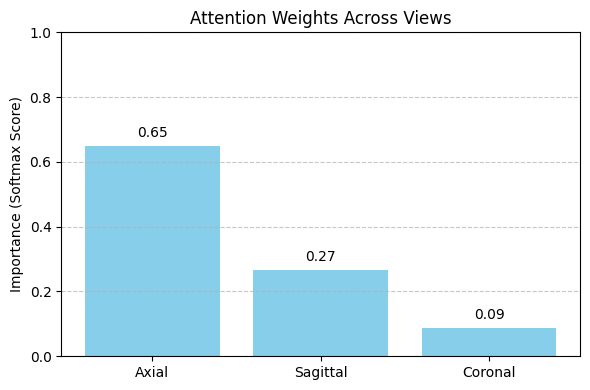

In [11]:
plot_view_attention_weights(model, timestamp)

In [20]:
def get_logits_and_labels(loader, model):
    model.eval()
    logits_list, labels_list = [], []

    with torch.no_grad():
        for batch in loader:
            x_axial = batch["axial"].to(device)
            x_sagittal = batch["sagittal"].to(device)
            x_coronal = batch["coronal"].to(device)
            x_meta = batch["meta"].to(device)
            y = batch["label"].cpu().numpy()

            outputs = model(x_axial, x_sagittal, x_coronal, x_meta)
            logits = outputs.cpu().numpy()  # shape: (batch,)
            logits_list.extend(logits)
            labels_list.extend(y)

    return np.array(logits_list).reshape(-1, 1), np.array(labels_list)

def calibrate_model():
    X_train_logits, y_train = get_logits_and_labels(train_loader, model)
    X_test_logits, y_test = get_logits_and_labels(test_loader, model)
    calibrator = LogisticRegressionCV(cv=5, solver='lbfgs')
    calibrator.fit(X_train_logits, y_train)
    y_proba_calibrated = calibrator.predict_proba(X_test_logits)[:, 1]

    return y_test, y_proba_calibrated, X_test_logits


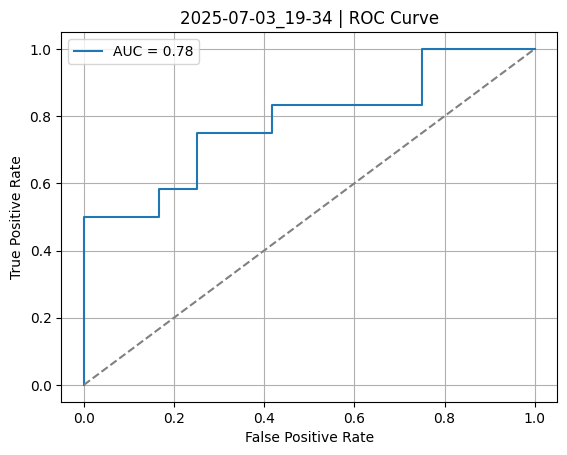

<Figure size 500x400 with 0 Axes>

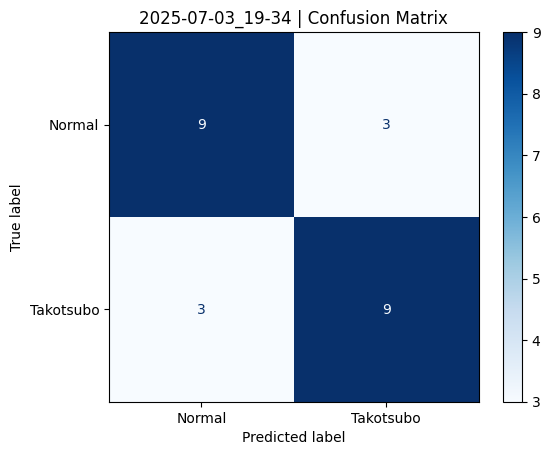

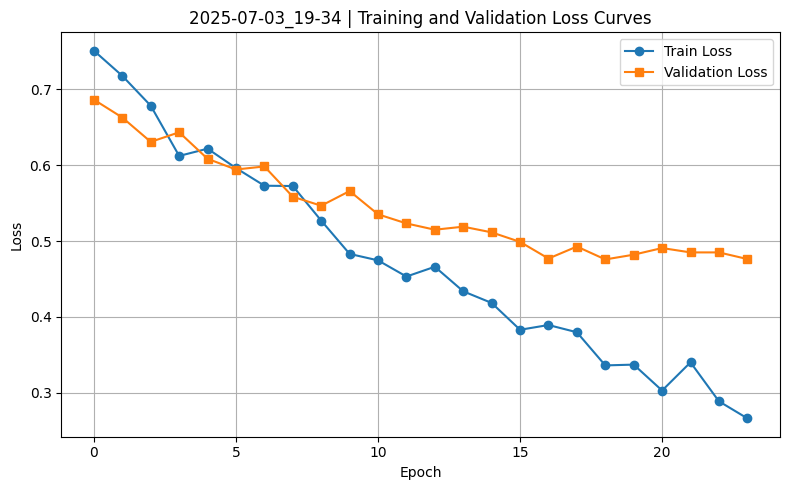

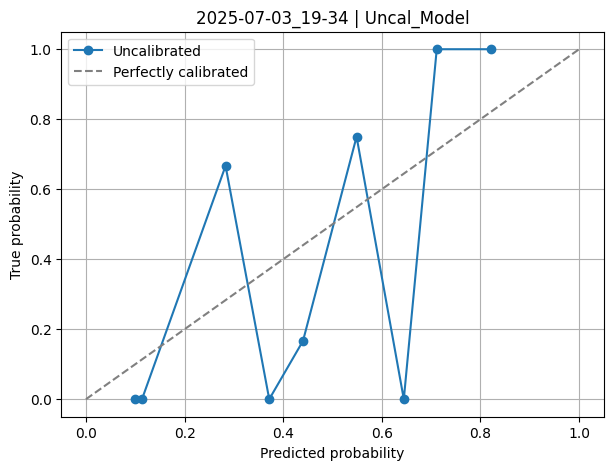

C:\Users\sulei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


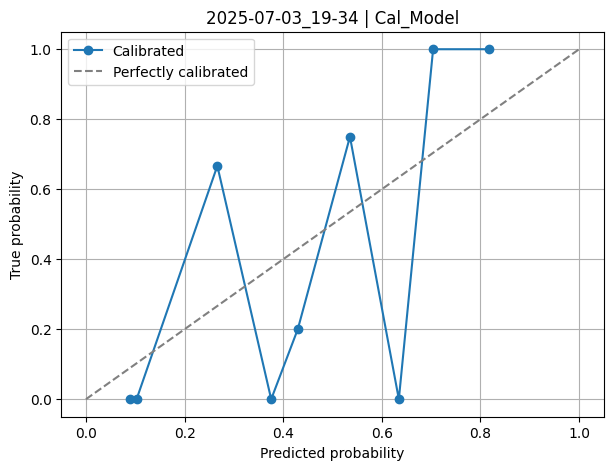

In [21]:
plot_roc_curve(y_true, y_prob, auc_score, timestamp)

plot_confusion_matrix(y_true, y_pred, timestamp)

plot_loss_curves(train_losses, val_losses, timestamp)



'''
Points above the line → the model is underconfident (true outcomes more frequent than predicted).
Points below the line → the model is overconfident (true outcomes less frequent than predicted).
'''

plot_calibration_curve(y_true, y_prob, timestamp, title="Uncal_Model", label="Uncalibrated")

y_test, y_proba_calibrated, X_test_logits = calibrate_model()
plot_calibration_curve(y_test, y_proba_calibrated, timestamp, title="Cal_Model", label="Calibrated")

cal_brier = brier_score_loss(y_test, y_proba_calibrated)



In [22]:
performance_df.loc[len(performance_df)] = {
    "timestamp": timestamp,
    "auc_score": f"{auc_score:.4f}",
    "normal_precision": f"{class_rep['Normal']['precision']:.4f}",
    "normal_recall": f"{class_rep['Normal']['recall']:.4f}",
    "normal_f1": f"{class_rep['Normal']['f1-score']:.4f}",
    "takotsubo_precision": f"{class_rep['Takotsubo']['precision']:.4f}",
    "takotsubo_recall": f"{class_rep['Takotsubo']['recall']:.4f}",
    "takotsubo_f1": f"{class_rep['Takotsubo']['f1-score']:.4f}",
    "accuracy": f"{class_rep['accuracy']:.4f}",
    "macro_precision": f"{class_rep['macro avg']['precision']:.4f}",
    "macro_recall": f"{class_rep['macro avg']['recall']:.4f}",
    "macro_f1": f"{class_rep['macro avg']['f1-score']:.4f}",
    "weighted_precision": f"{class_rep['weighted avg']['precision']:.4f}",
    "weighted_recall": f"{class_rep['weighted avg']['recall']:.4f}",
    "weighted_f1": f"{class_rep['weighted avg']['f1-score']:.4f}",
    "uncalibrated_brier": f"{uncal_brier:.4f}",
    "calibrated_brier": f"{cal_brier:.4f}"
}
performance_df.to_csv("logs/performance_log.csv", mode='a', header=not os.path.exists("logs/performance_log.csv"), index=False)

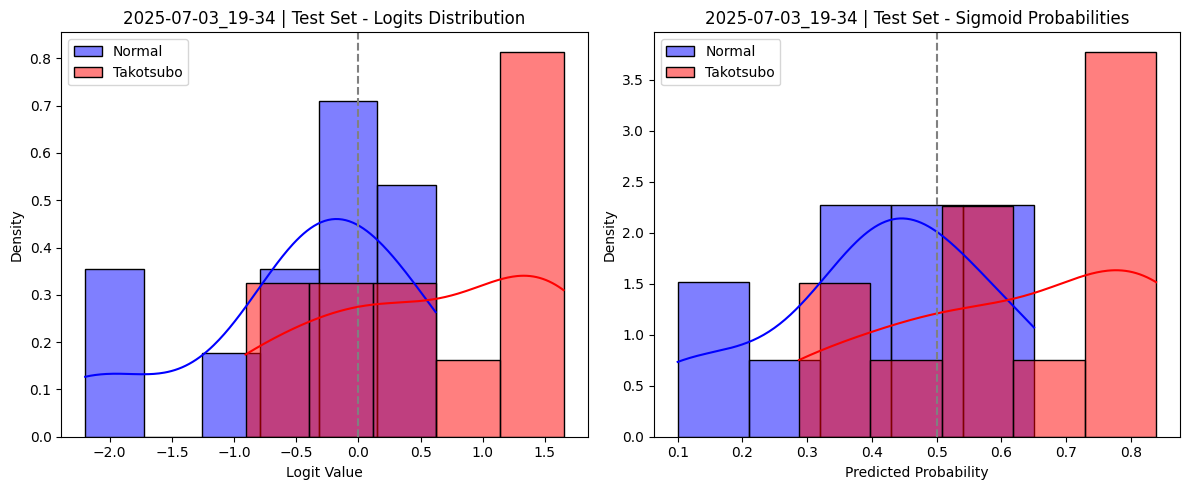

In [23]:
plot_logits_and_probs(X_test_logits.flatten(), y_test,timestamp, title_prefix="Test Set - ")

In [ ]:
def get_logits_labels_and_ids(loader, model):
    model.eval()
    logits_list, labels_list, patient_ids = [], [], []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            x_axial = batch["axial"].to(device)
            x_sagittal = batch["sagittal"].to(device)
            x_coronal = batch["coronal"].to(device)
            x_meta = batch["meta"].to(device)
            y = batch["label"].cpu().numpy()
            pid = batch["pid"]
            
            outputs = model(x_axial, x_sagittal, x_coronal, x_meta)
            logits = outputs.cpu().numpy()
            
            logits_list.extend(logits)
            labels_list.extend(y)
            patient_ids.extend([f"{pid}"])  # assumes 1 sample per batch

    return np.array(logits_list).flatten(), np.array(labels_list), patient_ids


logits, labels, patient_ids = get_logits_labels_and_ids(test_loader, model)
print(f"Logits shape: {logits.shape}, Labels shape: {labels.shape}, Patient IDs: {len(patient_ids)}")
probs = expit(logits)  # Sigmoid conversion
labels = np.array(labels).flatten()
df = pd.DataFrame({
    "timestamp" : timestamp,
    "Patient": patient_ids,
    "Label": labels,
    "Logit": logits,
    "Probability": probs,
    "Predicted": (probs > 0.5).astype(int),
    "Correct": (labels == (probs > 0.5).astype(int)),
    "Confidence": np.abs(probs - 0.5)
})

# Most uncertain (close to 0.5)
df_sorted = df.sort_values(by="Confidence", ascending=True)[]

# Top 5 most uncertain
print(df_sorted.head())

# Most confident wrong predictions
misclassified = df[~df["Correct"]]
#print(misclassified.sort_values(by="Confidence").head())
df_sorted.to_csv(f"misclassified.csv", index=False)

Logits shape: (24,), Labels shape: (24, 1), Patient IDs: 24
           timestamp            Patient  Label     Logit  Probability  \
10  2025-07-03_19-34   ['XZC 32444390']    1.0  0.068453     0.517107   
19  2025-07-03_19-34    ['HB 50159284']    0.0 -0.072913     0.481780   
5   2025-07-03_19-34     ['MC 3887643']    1.0  0.192498     0.547976   
22  2025-07-03_19-34  ['JSA 91708HDGH']    0.0  0.198592     0.549486   
20  2025-07-03_19-34    ['CB 11607017']    0.0 -0.212239     0.447139   

    Predicted  Correct  Confidence  
10          1     True    0.017107  
19          0     True    0.018220  
5           1     True    0.047976  
22          1    False    0.049486  
20          0     True    0.052861  


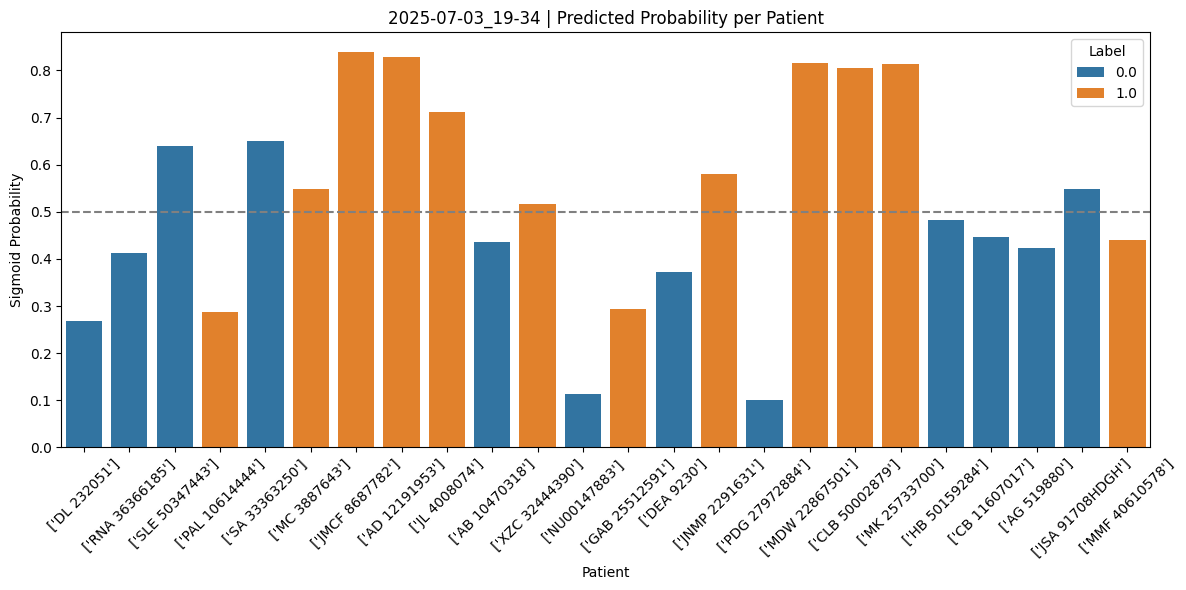

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Patient", y="Probability", hue="Label", data=df)
plt.axhline(0.5, linestyle='--', color='gray')
plt.title(f"{timestamp} | Predicted Probability per Patient")
plt.ylabel("Sigmoid Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"plots/{timestamp}_patient_probabilities.png", dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.show()

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [43]:
class AxialWrapper(nn.Module):
    def __init__(self, model, sagittal, coronal, meta):
        super().__init__()
        self.model = model
        self.sagittal = sagittal
        self.coronal = coronal
        self.meta = meta

    def forward(self, axial):
        output = self.model(axial, self.sagittal, self.coronal, self.meta)
        return output.unsqueeze(0)

class SagittalWrapper(nn.Module):
    def __init__(self, model, axial, coronal, meta):
        super().__init__()
        self.model = model
        self.axial = axial
        self.coronal = coronal
        self.meta = meta

    def forward(self, sagittal):
        output = self.model(self.axial, sagittal, self.coronal, self.meta)
        return output.unsqueeze(0)

class CoronalWrapper(nn.Module):
    def __init__(self, model, axial, sagittal, meta):
        super().__init__()
        self.model = model
        self.axial = axial
        self.sagittal = sagittal
        self.meta = meta

    def forward(self, coronal):
        output = self.model(self.axial, self.sagittal, coronal, self.meta)
        return output.unsqueeze(0)

In [41]:
target_layer = model.axial_branch.conv2
index = 9
batch = test_loader.dataset[index]
axial = batch["axial"].unsqueeze(0).to(device)
sagittal = batch["sagittal"].unsqueeze(0).to(device)
coronal = batch["coronal"].unsqueeze(0).to(device)
meta = batch["meta"].unsqueeze(0).to(device)
true_label = batch["label"]

In [44]:
# ----- AXIAL -----
axial_wrapper = AxialWrapper(model, sagittal, coronal, meta).to(device)
target_layer = model.axial_branch.conv2
cam = GradCAM(model=axial_wrapper, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=axial, targets=[ClassifierOutputTarget(int(true_label))])[0]

# Prepare image for overlay
input_img = axial.squeeze().permute(1, 2, 0).cpu().numpy()
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())
axial_cam_img = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)

# ----- SAGITTAL -----
sagittal_wrapper = SagittalWrapper(model, axial, coronal, meta).to(device)
target_layer = model.sagittal_branch.conv2
cam = GradCAM(model=sagittal_wrapper, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=sagittal, targets=[ClassifierOutputTarget(int(true_label))])[0]

input_img = sagittal.squeeze().permute(1, 2, 0).cpu().numpy()
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())
sagittal_cam_img = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)

# ----- CORONAL -----
coronal_wrapper = CoronalWrapper(model, axial, sagittal, meta).to(device)
target_layer = model.coronal_branch.conv2
cam = GradCAM(model=coronal_wrapper, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=coronal, targets=[ClassifierOutputTarget(int(true_label))])[0]

input_img = coronal.squeeze().permute(1, 2, 0).cpu().numpy()
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())
coronal_cam_img = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)

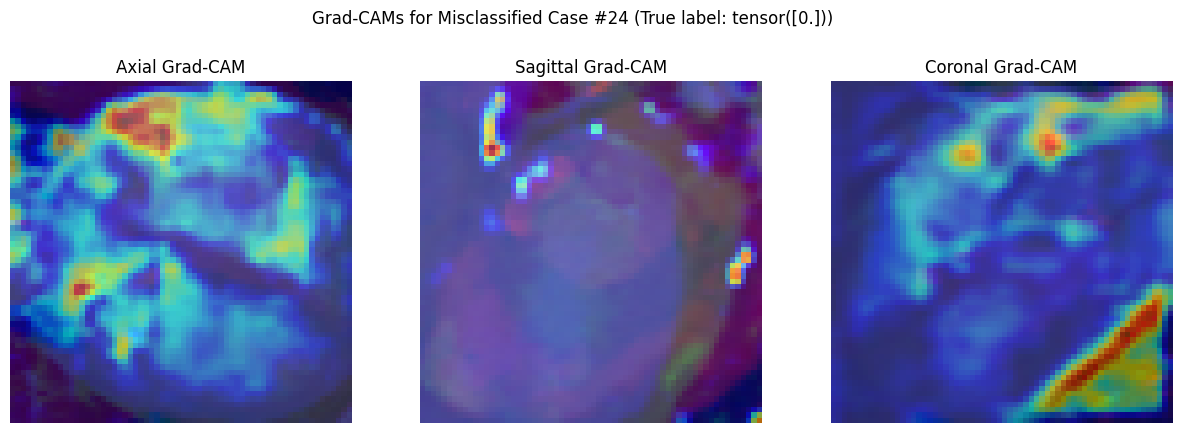

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(axial_cam_img)
plt.title("Axial Grad-CAM")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sagittal_cam_img)
plt.title("Sagittal Grad-CAM")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(coronal_cam_img)
plt.title("Coronal Grad-CAM")
plt.axis("off")

plt.suptitle(f"Grad-CAMs for Misclassified Case #{index} (True label: {true_label})")
plt.show()

In [32]:
# High uncertainty: confidence close to 0.5 (e.g., within ±0.2)
high_uncertainty_df = df_sorted[df_sorted["Confidence"] < 0.2]

# Misclassified samples
misclassified_df = df_sorted[df_sorted["Correct"] == False]

target_cases_df = df_sorted[(df_sorted["Confidence"] < 0.2) | (df_sorted["Correct"] == False)]

target_ids = target_cases_df["Patient"].str.extract(r"Case_\['(.+)'\]")[0].tolist()
print(target_ids)
patient_id = target_ids[0]  # Example patient ID to visualize
axial_slices = slices[patient_id]["Axial"]["ct"]

['SA 33363250', 'JL 4008074', 'JNMP 2291631', 'PAL 10614444', 'MC 3887643', 'CB 11607017', 'MMF 40610578', 'GAB 25512591', 'HB 50159284', 'DL 232051', 'JSA 91708HDGH', 'AB 10470318', 'RNA 36366185', 'XZC 32444390']


In [33]:
class MetadataModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, meta):
        # Create dummy tensors for image branches
        batch_size = meta.size(0)
        dummy = torch.zeros((batch_size, 3, 65, 65)).to(meta.device)
        return self.model(dummy, dummy, dummy, meta)
    
class MultiModalWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, axial, sagittal, coronal, meta):
        return self.model(axial, sagittal, coronal, meta)


def visualize_shap_by_class_and_error(shap_values, test_input, y_true, y_pred, view_names=["Axial", "Coronal", "Sagittal"]):
    """
    Visualizes SHAP explanations for correctly and incorrectly classified examples,
    split by class and by input view.
    
    Parameters:
    - shap_values: SHAP values output (list of [N, 3, H, W, 1] arrays).
    - test_input: Tuple of input tensors for each view (Axial, Coronal, Sagittal).
    - y_true: Ground truth labels (flattened numpy array).
    - y_pred: Predicted labels (flattened numpy array).
    - view_names: Names of the views (used in plot titles).
    """
    import shap
    import numpy as np

    idx = {
        "Takotsubo": np.where(y_true == 1)[0],
        "Normal": np.where(y_true == 0)[0],
        "FP": np.where((y_pred == 1) & (y_true == 0))[0],
        "FN": np.where((y_pred == 0) & (y_true == 1))[0],
    }

    for view_idx, view in enumerate(view_names):
        print(f"\n=== SHAP Visualizations for {view} View ===")

        for label, indices in idx.items():
            if len(indices) == 0:
                print(f"  No examples for {label}")
                continue

            shap_img = shap_values[0][indices, view_idx, :, :, 0]
            raw_img = test_input[view_idx][indices, 0, :, :].cpu().numpy()

            title = f"{view} - {label}"
            print(f"  Plotting {title} (n={len(indices)})")
            shap.image_plot(shap_img, raw_img, show=True)

meta_shap shape: (24, 2)
meta_input shape: (24, 2)


C:\Users\sulei\AppData\Local\Temp\ipykernel_8684\453916837.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


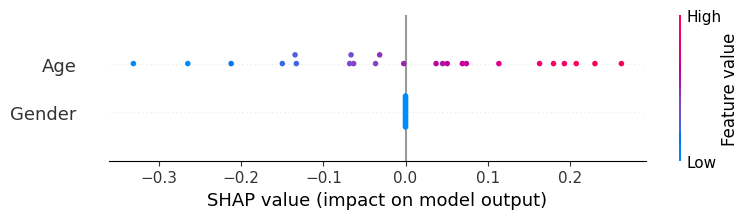

<Figure size 640x480 with 0 Axes>

In [35]:
# Collect background (for DeepExplainer) and test examples
bg_axial, bg_sagittal, bg_coronal, bg_meta = [], [], [], []
test_axial, test_sagittal, test_coronal, test_meta = [], [], [], []

with torch.no_grad():
    for i, batch in enumerate(dataset_loader.get_val_loader()):
        if i >= 10: break  # Limit background
        bg_axial.append(batch["axial"])
        bg_sagittal.append(batch["sagittal"])
        bg_coronal.append(batch["coronal"])
        bg_meta.append(batch["meta"])

    for batch in dataset_loader.get_test_loader():
        test_axial.append(batch["axial"])
        test_sagittal.append(batch["sagittal"])
        test_coronal.append(batch["coronal"])
        test_meta.append(batch["meta"])

# Stack all background and test tensors
bg_input = [
    torch.cat(bg_axial).to(device),
    torch.cat(bg_sagittal).to(device),
    torch.cat(bg_coronal).to(device),
    torch.cat(bg_meta).to(device),
]

test_input = [
    torch.cat(test_axial).to(device),
    torch.cat(test_sagittal).to(device),
    torch.cat(test_coronal).to(device),
    torch.cat(test_meta).to(device),
]

#explainer = shap.DeepExplainer(MultiModalWrapper(model), bg_input)
#shap_values = explainer.shap_values(test_input, check_additivity=False)

explainer = shap.GradientExplainer(MultiModalWrapper(model), bg_input)
shap_values = explainer.shap_values(test_input)

meta_shap = shap_values[3]               # SHAP values for metadata branch (shape: [n_samples, 2])
meta_shap = np.squeeze(meta_shap)
meta_input = test_input[3].cpu().numpy() # Original input values for metadata

print("meta_shap shape:", meta_shap.shape)       # should be (n_samples, 2)
print("meta_input shape:", meta_input.shape)

shap.summary_plot(
    meta_shap,
    features=meta_input,
    feature_names=["Age", "Gender"]
)
plt.tight_layout()
plt.savefig(f"{timestamp}_shap_metadata.png", dpi=300, bbox_inches='tight')

In [38]:

# ---- Collect logits and labels from your trained CNN ----
def get_logits_and_labels(dataloader, model):
    model.eval()
    logits_list, labels_list = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            x_axial = batch["axial"].to(device)
            x_sagittal = batch["sagittal"].to(device)
            x_coronal = batch["coronal"].to(device)
            x_meta = batch["meta"].to(device)
            y = batch["label"].to(device)

            outputs = model(x_axial, x_sagittal, x_coronal, x_meta)  # (batch_size, 1)
            logits_list.append(outputs.cpu().numpy())     # raw logits
            labels_list.append(y.cpu().numpy())

    logits = np.concatenate(logits_list)
    labels = np.concatenate(labels_list)
    return logits.reshape(-1, 1), labels

# Get uncalibrated model outputs (logits)
logits_train, y_train = get_logits_and_labels(train_loader, model)
logits_val, y_val = get_logits_and_labels(val_loader, model)
logits_test, y_test = get_logits_and_labels(test_loader, model)

100%|██████████| 24/24 [00:00<00:00, 271.59it/s]


C:\Users\sulei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


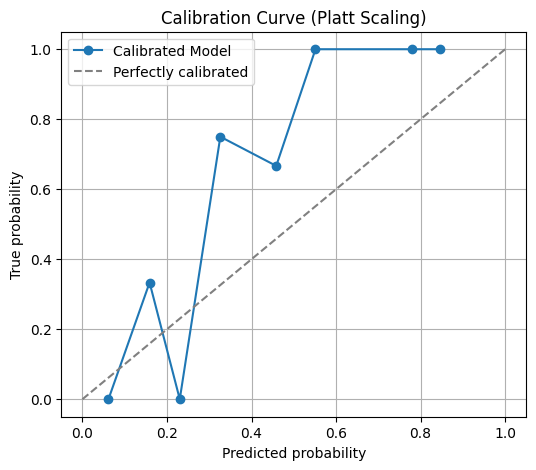

In [39]:
# Train on train set
base_model = LogisticRegression()
base_model.fit(logits_train, y_train)

# Calibrate on validation set
calibrated_clf = CalibratedClassifierCV(base_model, method='sigmoid', cv='prefit')
calibrated_clf.fit(logits_val, y_val)

y_prob_calibrated = calibrated_clf.predict_proba(logits_test)[:, 1]  # calibrated probs
prob_true, prob_pred = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve (Platt Scaling)")
plt.legend()
plt.grid(True)
plt.show()